In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("crime_dataset_india.csv")
df.head()

,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed
0,1,02-01-2020 00:00,01-01-2020 00:00,01-01-2020 01:11,Ahmedabad,576,IDENTITY THEFT,16,M,Blunt Object,Violent Crime,13,No,NaN
1,2,01-01-2020 19:00,01-01-2020 01:00,01-01-2020 06:26,Chennai,128,HOMICIDE,37,M,Poison,Other Crime,9,No,NaN
2,3,02-01-2020 05:00,01-01-2020 02:00,01-01-2020 14:30,Ludhiana,271,KIDNAPPING,48,F,Blunt Object,Other Crime,15,No,NaN
3,4,01-01-2020 05:00,01-01-2020 03:00,01-01-2020 14:46,Pune,170,BURGLARY,49,F,Firearm,Other Crime,1,Yes,29-04-2020 05:00
4,5,01-01-2020 21:00,01-01-2020 04:00,01-01-2020 16:51,Pune,421,VANDALISM,30,F,Other,Other Crime,18,Yes,08-01-2020 21:00


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40160 entries, 0 to 40159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Report Number       40160 non-null  int64 
 1   Date Reported       40160 non-null  object
 2   Date of Occurrence  40160 non-null  object
 3   Time of Occurrence  40160 non-null  object
 4   City                40160 non-null  object
 5   Crime Code          40160 non-null  int64 
 6   Crime Description   40160 non-null  object
 7   Victim Age          40160 non-null  int64 
 8   Victim Gender       40160 non-null  object
 9   Weapon Used         34370 non-null  object
 10  Crime Domain        40160 non-null  object
 11  Police Deployed     40160 non-null  int64 
 12  Case Closed         40160 non-null  object
 13  Date Case Closed    20062 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.3+ MB


In [4]:
df.isnull().sum()

Report Number             0
Date Reported             0
Date of Occurrence        0
Time of Occurrence        0
City                      0
Crime Code                0
Crime Description         0
Victim Age                0
Victim Gender             0
Weapon Used            5790
Crime Domain              0
Police Deployed           0
Case Closed               0
Date Case Closed      20098
dtype: int64

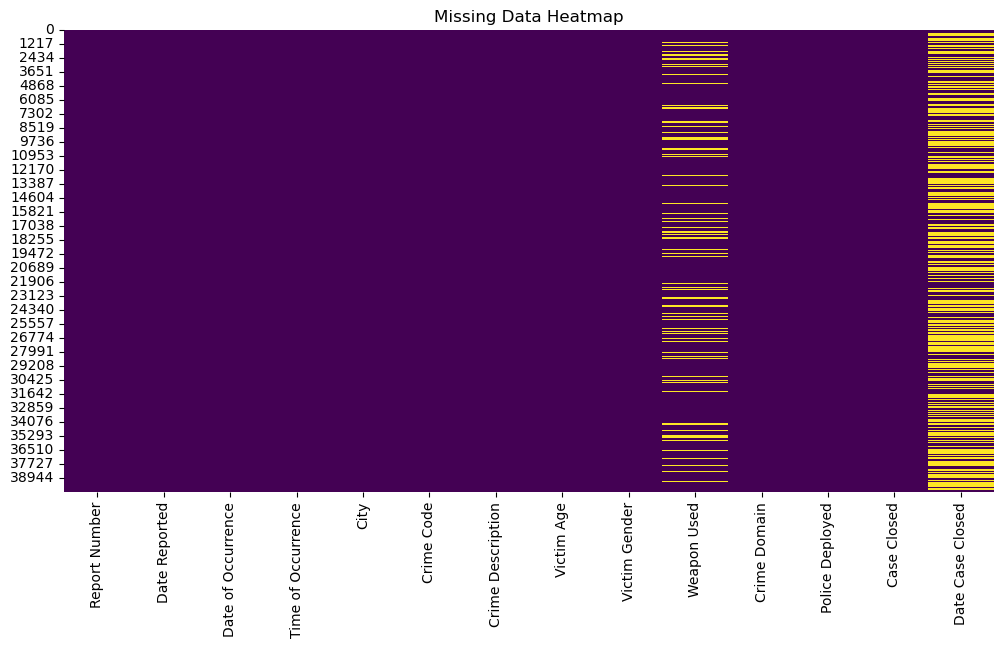

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

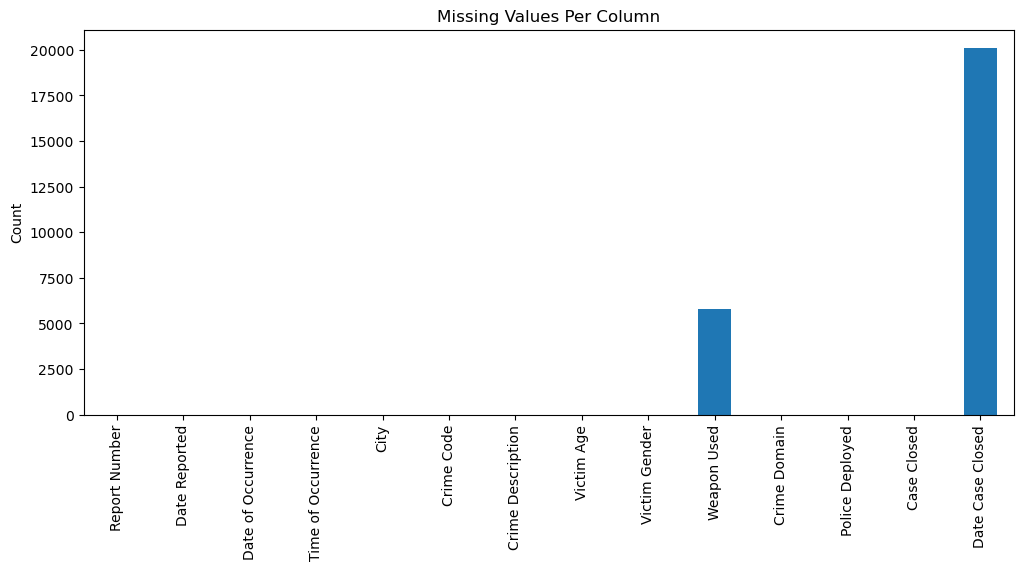

In [6]:
df.isnull().sum().plot(kind='bar', figsize=(12,5))
plt.title("Missing Values Per Column")
plt.ylabel("Count")
plt.show()

In [7]:
# Fill numerical columns with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
#Feature Engineering
#Convert Dates to Year

df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce')
df['Year'] = df['Date Reported'].dt.year

In [9]:
#Crime Count Per City (Crime Rate Approximation)

crime_count_city = df.groupby('City').size().reset_index(name='Total_Crime')
df = df.merge(crime_count_city, on='City')

In [10]:
#Creating Crime-Prone Label (For SVM)

threshold = df['Total_Crime'].median()

df['Crime_Prone'] = df['Total_Crime'].apply(
    lambda x: 1 if x > threshold else 0
)

df[['City', 'Total_Crime', 'Crime_Prone']].head()

,City,Total_Crime,Crime_Prone
0,Ahmedabad,1817,0
1,Chennai,2493,0
2,Ludhiana,761,0
3,Pune,2212,0
4,Pune,2212,0


In [11]:
#Encode Categorical Features

le = LabelEncoder()

encode_cols = [
    'City',
    'Crime Description',
    'Victim Gender',
    'Weapon Used',
    'Crime Domain',
    'Case Closed'
]

for col in encode_cols:
    df[col] = le.fit_transform(df[col])


In [12]:
#Feature Selection & Scaling (SVM)

X = df[['City', 'Crime Description', 'Victim Age', 'Police Deployed', 'Year']]
y = df['Crime_Prone']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Check NaNs in selected features
print(X.isnull().sum())

# Replace any remaining NaNs with median
X = X.fillna(X.median())

City                     0
Crime Description        0
Victim Age               0
Police Deployed          0
Year                 24286
dtype: int64


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)


In [16]:
#Train SVM Classifier
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

SVC(C=1)

In [17]:
#SVM Evaluation
y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6929282868525897

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.46      0.61      5340
           1       0.61      0.96      0.75      4700

    accuracy                           0.69     10040
   macro avg       0.77      0.71      0.68     10040
weighted avg       0.78      0.69      0.68     10040



In [20]:
##CRIME RATE FORECASTING (REGRESSION)
# Check missing values in regression features
print(X_reg.isnull().sum())

# Fill remaining NaNs with median
X_reg = X_reg.fillna(X_reg.median())


City                   0
Year               24286
Police Deployed        0
dtype: int64


In [21]:
#Prepare Data for Regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42)


In [22]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_r, y_train_r)

LinearRegression()

In [24]:
# Predict using Linear Regression
y_pred_lr = lr.predict(X_test_r)

In [25]:
print("MAE:", mean_absolute_error(y_test_r, y_pred_lr))
print("MSE:", mean_squared_error(y_test_r, y_pred_lr))
print("R2 Score:", r2_score(y_test_r, y_pred_lr))

MAE: 1246.5826561086903
MSE: 2330700.709840025
R2 Score: 0.14256301405648197


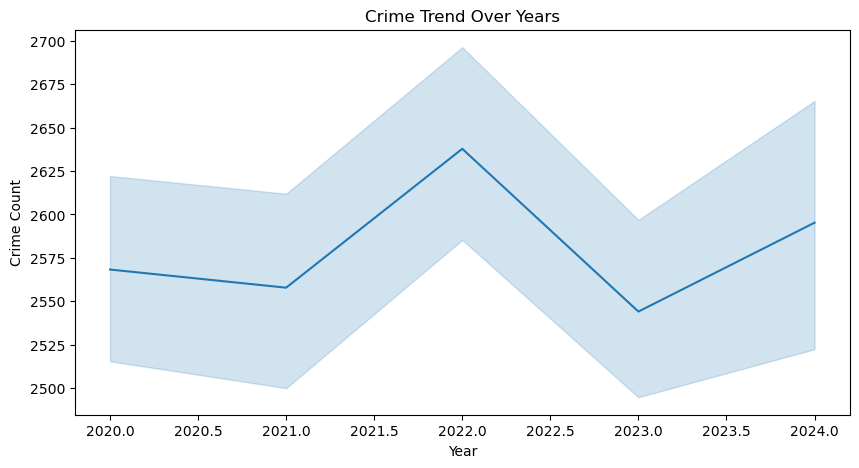

In [26]:
#Crime Trend Visualization
plt.figure(figsize=(10,5))
sns.lineplot(x=df['Year'], y=df['Total_Crime'])
plt.title("Crime Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

In [29]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf_model.fit(X_train_r, y_train_r)


RandomForestRegressor(random_state=42)

In [30]:
#Save Models (For Streamlit)
import joblib

joblib.dump(svm_model, "svm_crime_model.pkl")
joblib.dump(rf_model, "rf_crime_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']